In [24]:
import datetime as dt
import os

import numpy as np
import numpyro
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    facet_grid,
    geom_ribbon,
    ggplot,
    scale_x_datetime,
    theme_bw,
    theme
)
from sklearn.gaussian_process import kernels
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from src.step1_data_loading.data_loading import load_data
from src.step2_preprocessing.preprocessing import XArrayScaler, flatten_array
from src.step3_modeling import MonthlyAverage
from src.step3_modeling.gaussian_process import SklearnGPModel
from src.step3_modeling.metrics import summarize
from src.step3_modeling.modeling import ModelBase
from src.step3_modeling.var_models import GLRVAR
from src.utils import create_rnbs_snapshot

# device = "cuda"
device = "cpu"

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

In [25]:
def split_data(split_date, lake_data, validation_steps=12, num_years_ahead=1):
    covars = lake_data.sel(type="Basin")[["precip", "evap", "temp"]].to_array().transpose("Date", "lake", ...)
    y_scaler = XArrayScaler()
    y_vals = y_scaler.fit_transform(lake_data["rnbs"])
    lake_snapshot = create_rnbs_snapshot(rnbs_data=y_vals,
                                         covariates=covars,
                                         split_date=split_date,
                                         validation_steps=validation_steps, sequential_validation=True,
                                         num_years_forward=num_years_ahead)
    return lake_snapshot, y_scaler


lake_data = load_data(["rnbs", "precip", "evap", "temp"]).dropna("Date").transpose("Date", "lake", ...)

train_split = dt.datetime(1999, 12, 1)
snapshot, y_scaler = split_data(train_split, lake_data)

scaled_rnbs = XArrayScaler().fit_transform(lake_data["rnbs"])

snapshot.train_y

<xarray.DataArray 'rnbs' (Date: 240, lake: 4)>
array([[-1.18710356e+00, -4.79767891e-01,  1.18010055e-01,
         7.31526068e-01],
       [-3.96996869e-01, -4.91255064e-01,  5.88664558e-01,
        -4.76262581e-01],
       [ 1.14108578e+00,  2.22787517e+00,  1.79230574e+00,
         2.43288709e+00],
       [ 1.68939841e+00,  2.64999989e+00,  2.12747371e+00,
         2.32571709e+00],
       [ 2.74053276e+00,  1.54775618e+00,  6.15514984e-01,
         4.55629065e-01],
       [ 2.00538007e+00,  9.76609632e-01,  1.18318677e-01,
        -4.22121578e-01],
       [ 6.82073093e-01, -2.10286873e-01, -3.79495056e-01,
        -8.89365459e-01],
       [-1.35448004e-02,  5.11536952e-01, -4.27332080e-01,
        -8.89365459e-01],
       [-7.36880909e-02, -1.65610865e+00, -4.83502002e-01,
        -7.11367806e-01],
       [ 1.99399453e-01, -8.32659707e-01, -1.03007872e+00,
        -4.98512247e-01],
...
       [ 1.75738932e-01,  1.84611056e+00,  1.39047495e+00,
         2.30643457e+00],
       [ 1.36966346e-01,  1.30569910e+00,  1.48861797e+00,
         9.12861068e-01],
       [ 3.36630097e-01,  4.95497598e-01, -6.36624541e-03,
         1.87932380e-02],
       [ 9.42948620e-01,  2.56337677e-01, -1.96479854e-01,
        -1.05023124e-02],
       [-4.86753914e-01, -1.10534895e+00, -5.23006129e-01,
        -6.59451810e-01],
       [-7.32822781e-01, -6.49797638e-01, -6.47382439e-01,
        -9.46843892e-01],
       [-1.06284802e+00, -1.53813305e+00, -1.75195498e+00,
        -1.60135615e+00],
       [-1.05460497e+00, -1.67318399e+00, -1.69979679e+00,
        -1.72855032e+00],
       [-5.31632581e-01, -9.14104313e-01, -1.78898968e+00,
        -1.27873540e+00],
       [-1.08772972e+00, -1.44861652e+00, -1.03007872e+00,
        -1.18825324e+00]])
Coordinates:
  * Date     (Date) datetime64[ns] 1979-01-01 1979-02-01 ... 1998-12-01
  * lake     (lake) object 'sup' 'mic_hur' 'eri' 'ont'

In [31]:
default_preprocessor = Pipeline(steps=[
    ("scale", XArrayScaler())
])

gp_preprocessor = Pipeline(steps=[
    ("scale", XArrayScaler()),
    ("flatten", FunctionTransformer(flatten_array))
])

gp_models = {
    "GP_Matern": SklearnGPModel(1.0 * kernels.Matern()),
    "GP_RQMatern": SklearnGPModel(1.0 * kernels.Matern() * kernels.RationalQuadratic()),
}
gp_models = {
    k: Pipeline(steps=[("preprocessor", gp_preprocessor), ("model", v)]) for k, v in gp_models.items()
}

all_models = {
    "Default": Pipeline(steps=[("preprocessor", default_preprocessor), ("model", MonthlyAverage())]),
    "GLRVARX": Pipeline(steps=[
        ("preprocessor", default_preprocessor),
        ("model", GLRVAR(lags={"y": 3, "precip": 6, "temp": 1}, num_chains=4, num_samples=1000, num_warmup=500))]
    ),
    **gp_models
}


In [32]:
def fit_model(fit_snapshot, model):
    model.fit(y=fit_snapshot.train_y, X=fit_snapshot.train_x)
    return model


def run_forecasts(start_date, fitted_model: ModelBase, num_years_ahead=10):
    rnbs = scaled_rnbs.rename("true")
    all_dfs = []
    for i in range(12 * num_years_ahead + 1):
        new_split = start_date + relativedelta(months=i)
        new_snapshot, _ = split_data(new_split, lake_data, validation_steps=0, num_years_ahead=1)
        predictions = fitted_model.predict(X=new_snapshot.test_x, y=new_snapshot.test_y, forecast_steps=12)

        months_ahead = xr.DataArray(np.arange(1, 13), dims="Date", coords={"Date": predictions.indexes["Date"]},
                                    name="months_ahead")
        merged_ds = xr.merge([predictions, rnbs, months_ahead]).dropna("Date")
        comparison_df = merged_ds.to_dataframe(["Date", "lake", "value"]).reset_index(
            names=["Date", "lake", "value"]).pivot(index=["Date", "lake", "months_ahead", "true"], columns="value",
                                                   values="forecasts").reset_index()
        all_dfs.append(comparison_df)
    return pd.concat(all_dfs)


snapshot, y_scaler = split_data(train_split, lake_data, num_years_ahead=10, validation_steps=0)
all_model_results = []
for name, model in all_models.items():
    fitted_model = fit_model(snapshot, model)
    predictions = run_forecasts(train_split, model).assign(model=name)
    all_model_results.append(predictions)

results_df = pd.concat(all_model_results)
results_df.head()

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

value,Date,lake,months_ahead,true,lower,mean,std,upper,model
0,2000-01-01,eri,1.0,-0.723922,-0.516070,0.273959,0.662781,1.577518,Default
1,2000-01-01,mic_hur,1.0,-1.021938,-0.754623,-0.241085,0.351393,0.273175,Default
2,2000-01-01,ont,1.0,-0.601973,-0.803148,0.128003,0.805145,1.682219,Default
3,2000-01-01,sup,1.0,-1.078265,-1.381474,-0.965642,0.323184,-0.437658,Default
4,2000-02-01,eri,2.0,0.143626,-0.317106,0.604052,0.805020,1.645400,Default


In [33]:
results_df.groupby(["months_ahead", "model"]).apply(summarize, include_groups=False)

rmse  variance      bias  coverage  \
months_ahead model                                                 
1.0          Default      0.683948  0.455180  0.112271  0.768595   
             GLRVARX      0.777365  0.604296 -0.000502  0.915289   
             GP_Matern    0.457651  0.207969  0.038407  0.933884   
             GP_RBF       0.558398  0.306432  0.073320  0.913223   
             GP_RQMatern  0.388039  0.149999  0.024002  0.954545   
2.0          Default      0.683700  0.455024  0.111453  0.768595   
             GLRVARX      0.757201  0.573351  0.001640  0.940083   
             GP_Matern    0.459945  0.210163  0.037235  0.935950   
             GP_RBF       0.560987  0.309550  0.071810  0.915289   
             GP_RQMatern  0.391125  0.152333  0.025410  0.952479   
3.0          Default      0.684858  0.456380  0.112474  0.770661   
             GLRVARX      0.756977  0.573014  0.000048  0.946281   
             GP_Matern    0.462112  0.212321  0.035016  0.933884   
             GP_RBF       0.563254  0.312397  0.069704  0.913223   
             GP_RQMatern  0.391642  0.152938  0.021098  0.952479   
4.0          Default      0.689916  0.462055  0.118021  0.768595   
             GLRVARX      0.759175  0.576241  0.010237  0.954545   
             GP_Matern    0.466448  0.216234  0.036601  0.931818   
             GP_RBF       0.566673  0.316255  0.069737  0.911157   
             GP_RQMatern  0.396467  0.156592  0.024373  0.948347   
5.0          Default      0.691312  0.463796  0.118810  0.766529   
             GLRVARX      0.755037  0.569937  0.011952  0.950413   
             GP_Matern    0.466601  0.216639  0.032819  0.931818   
             GP_RBF       0.566332  0.316691  0.063565  0.911157   
             GP_RQMatern  0.396683  0.156841  0.022727  0.948347   
6.0          Default      0.688297  0.459126  0.120943  0.766529   
             GLRVARX      0.753657  0.567881  0.010890  0.956612   
             GP_Matern    0.466229  0.216461  0.030127  0.931818   
             GP_RBF       0.570110  0.321858  0.056283  0.911157   
             GP_RQMatern  0.396006  0.156343  0.021851  0.948347   
7.0          Default      0.686701  0.455404  0.127099  0.766529   
             GLRVARX      0.745578  0.555516  0.019239  0.958678   
             GP_Matern    0.466844  0.217005  0.030625  0.929752   
             GP_RBF       0.569824  0.321307  0.058244  0.909091   
             GP_RQMatern  0.396967  0.157111  0.021734  0.948347   
8.0          Default      0.685815  0.453838  0.128472  0.766529   
             GLRVARX      0.749221  0.560798  0.023096  0.960744   
             GP_Matern    0.467360  0.217520  0.030101  0.931818   
             GP_RBF       0.569988  0.321216  0.060581  0.913223   
             GP_RQMatern  0.398577  0.158501  0.019043  0.948347   
9.0          Default      0.686806  0.454593  0.130801  0.764463   
             GLRVARX      0.751699  0.564419  0.025138  0.958678   
             GP_Matern    0.469551  0.219202  0.035724  0.933884   
             GP_RBF       0.573806  0.324662  0.067754  0.917355   
             GP_RQMatern  0.399596  0.159197  0.021917  0.948347   
10.0         Default      0.687918  0.456899  0.127797  0.762397   
             GLRVARX      0.751781  0.564472  0.026497  0.958678   
             GP_Matern    0.472790  0.222251  0.035766  0.933884   
             GP_RBF       0.575903  0.327120  0.067411  0.915289   
             GP_RQMatern  0.402214  0.161329  0.021140  0.946281   
11.0         Default      0.686484  0.454902  0.127902  0.768595   
             GLRVARX      0.754676  0.568629  0.030103  0.962810   
             GP_Matern    0.474485  0.223722  0.037597  0.933884   
             GP_RBF       0.577110  0.328343  0.068644  0.915289   
             GP_RQMatern  0.402575  0.161593  0.021765  0.946281   
12.0         Default      0.685111  0.453621  0.125525  0.768595   
             GLRVARX      0.755196  0.569388  0.030556  0.960744   
             GP_Ma

/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanea

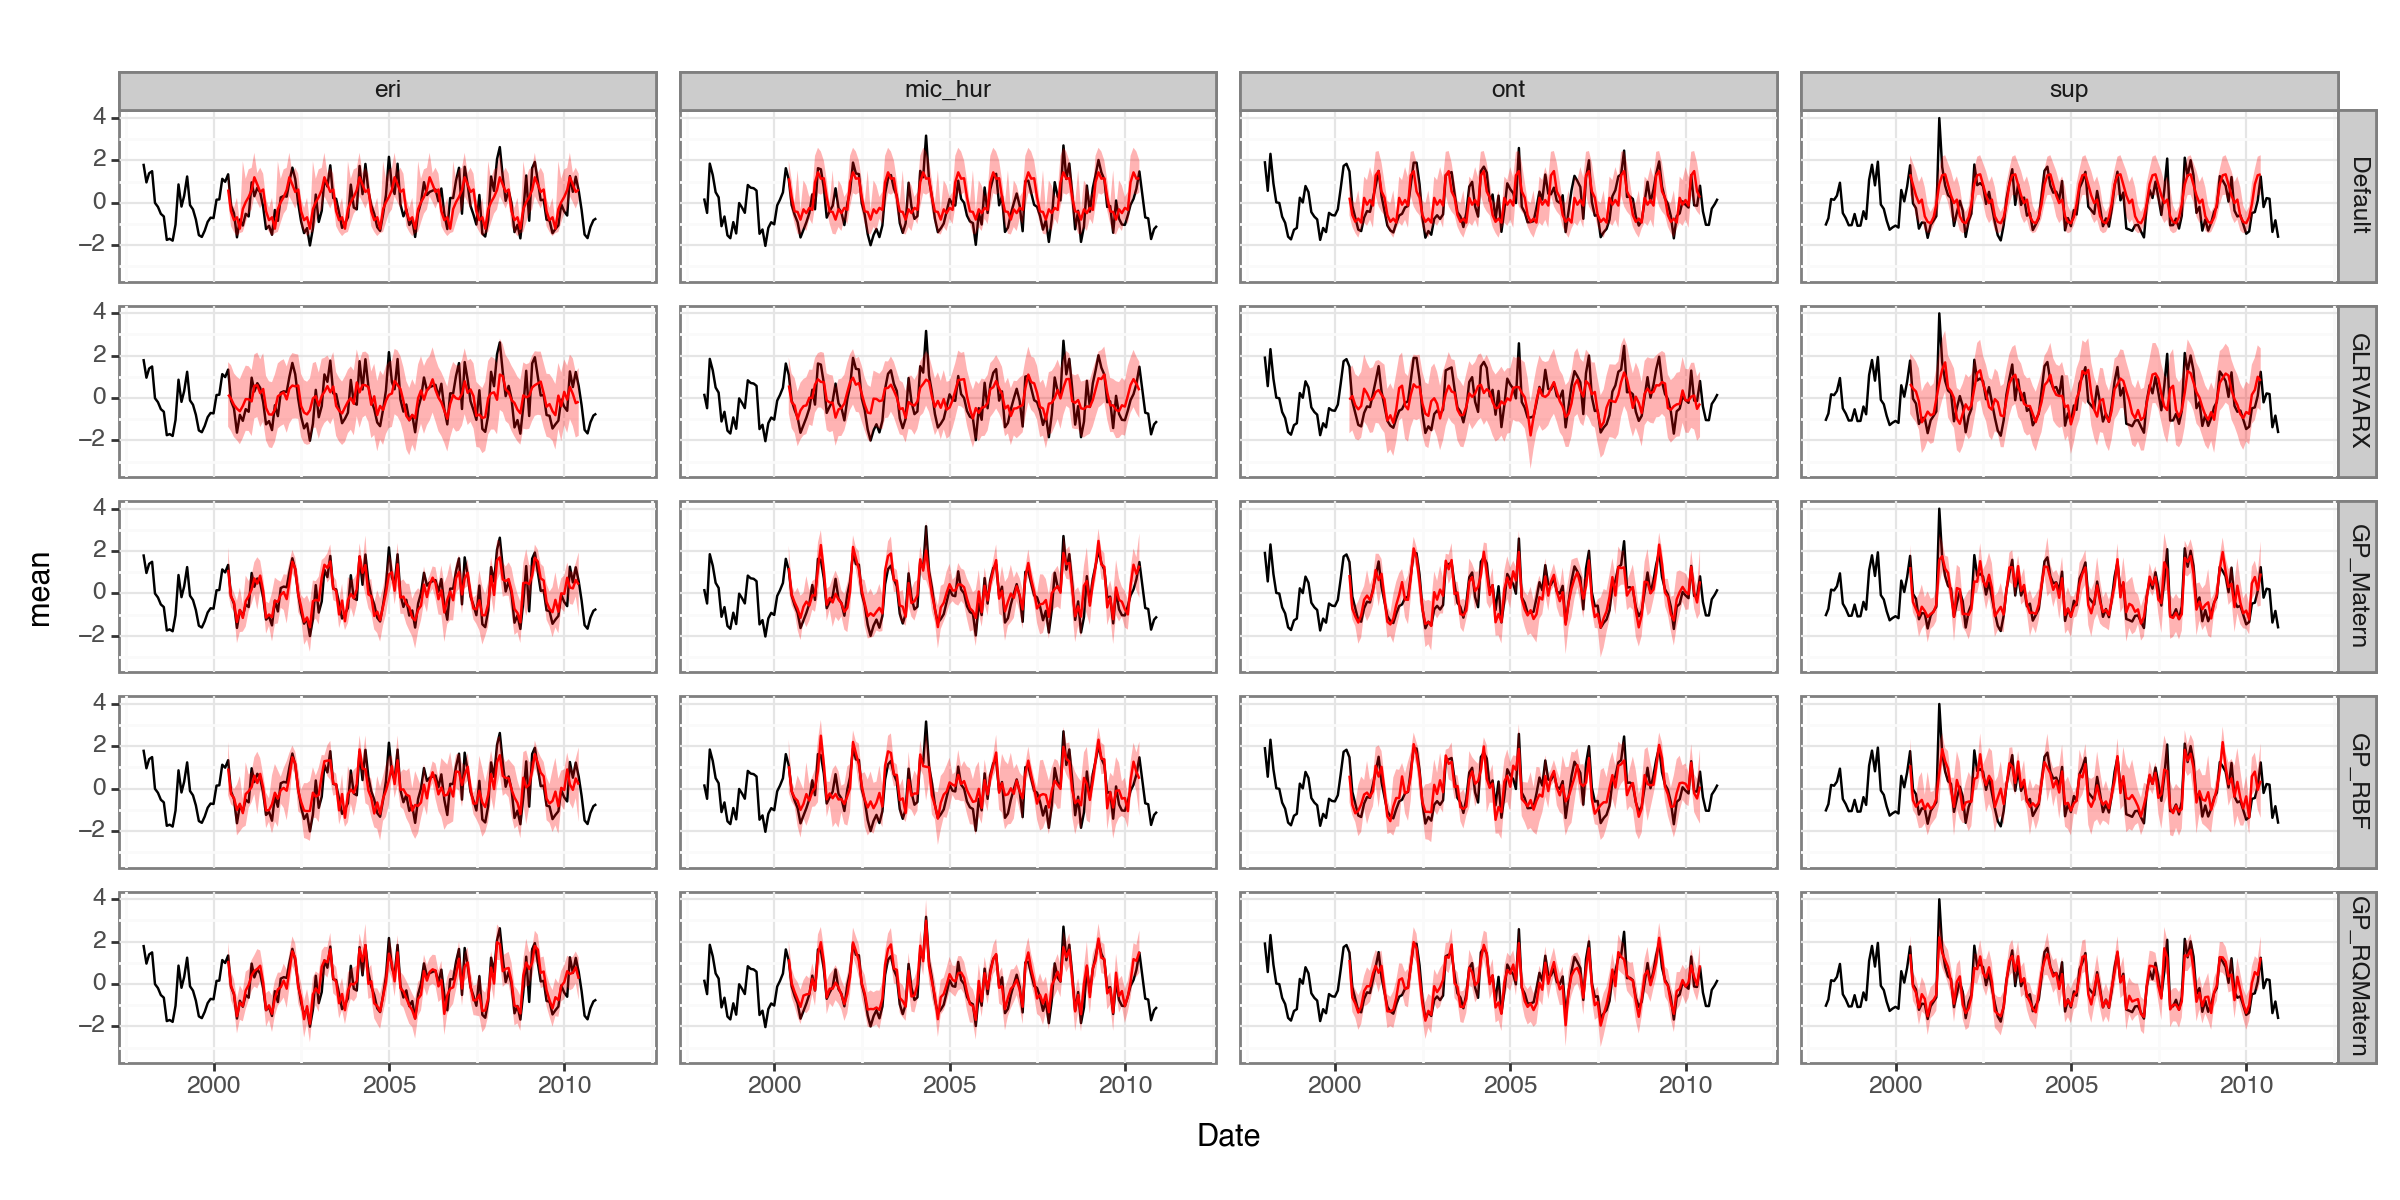

<Figure Size: (1200 x 600)>

In [34]:
og = scaled_rnbs.to_dataframe(name="rnbs").reset_index()
result_subset = results_df[results_df["months_ahead"].isin([6])]

(
        ggplot(data=result_subset, mapping=aes(x="Date", y="mean"))
        + geom_line(data=og, mapping=aes(x="Date", y="rnbs"), inherit_aes=False)
        + geom_line(mapping=aes(x="Date", y="mean"), color="red")
        + facet_grid("model~lake")
        + scale_x_datetime(
    limits=[results_df.Date.min() - relativedelta(years=2), results_df.Date.max() + relativedelta(years=1)],
    labels=date_format(fmt="%Y"), breaks=date_breaks("5 year"))
        + geom_ribbon(
    mapping=aes(x="Date", ymin="lower", ymax="upper"), fill="red", alpha=0.3,
)
        + theme_bw()
        + theme(figure_size=(12, 6))
)
